In [2]:
] activate .

  Activating project at `~/Projects/HTM/Notebooks`


In [3]:
using CSV
using Plots
using ProgressMeter
using Random

In [4]:
include("temporal_mem_thresholder.jl")

Test Summary: | Pass  Total
TMThreshold   |   16     16
(value = nothing, time = 0.00925101, bytes = 6354216, gctime = 0.0, gcstats = Base.GC_Diff(6354216, 64, 0, 2334, 513, 0, 0, 0, 0))


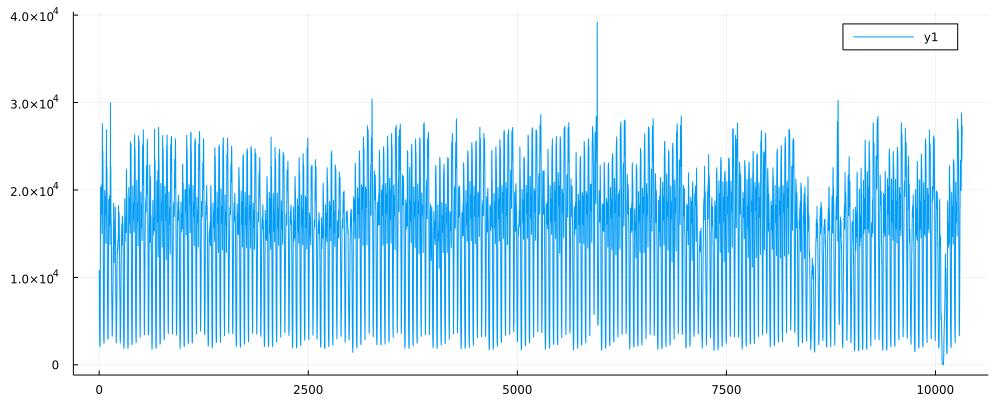

In [5]:
csv = CSV.File("../nyc_taxi.csv")
X = csv["value"]
plot(X, size=(1000, 400))

In [6]:
"""
    which_bin(x, bin_width, start, stop)

Assumes a set of intervals with width `bin_width` between 
`start` and `stop`. Returns the index which interval
`x` belongs to.
"""
function which_bin(x, bin_width, start, stop)
    if x > stop 
        i = floor(Int, (stop - start) / bin_width)
    elseif x < start
        i = 0
    else
        i = floor(Int, (x - start) / bin_width)
    end
    return i + 1
end

# Make evenly spaced intervals for taxi data
num_bins = 101
bins = LinRange(minimum(X), maximum(X), num_bins)
bin_size = bins[2] - bins[1]

# Make a function that assigns data to the appropriate bin index
taxi_bin(x) = which_bin(x,  bin_size, bins.start, bins.stop)

taxi_bin (generic function with 1 method)

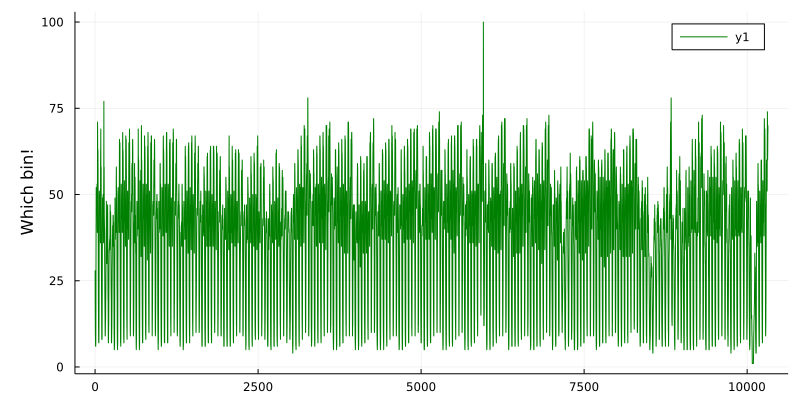

In [7]:
Z = map(taxi_bin, X)
plot(Z, c=:green, size=(800, 400))
ylabel!("\n\nWhich bin!") 

In [8]:
ENC_LEN = 500
ENC_ACTIVE = 15
encodings = Dict(i => sample(1:ENC_LEN, ENC_ACTIVE; replace=false) for i in 1:(num_bins + 1));

In [9]:
num_cols = 500
cells_per_col = 15
num_cells = num_cols * cells_per_col

# Segments and synapses
segments_per_cell = 64
synapses_per_segment = 50
segment_sparsity = synapses_per_segment / num_cells;

tmt = TMThreshold(
    num_cells, 
    cells_per_col, 
    segments_per_cell, 
    synapses_per_segment,
    very_small_incr=1e-5,
    initial_threshold = 2.0,  
)

TMThreshold

In [10]:
    
training_len = 7500
prev_active_cols = collect(1:15)
epochs = 100

@showprogress for i in 1:epochs
    for x in X[1:training_len]
        segment_activations = project(tmt, prev_active_cols)
        next_active_cols = encodings[taxi_bin(x)]
        update!(tmt, segment_activations, next_active_cols)
        prev_active_cols = next_active_cols
    end
end


Progress:  14%|█████▊                                   |  ETA: 2:26:21

LoadError: InterruptException:

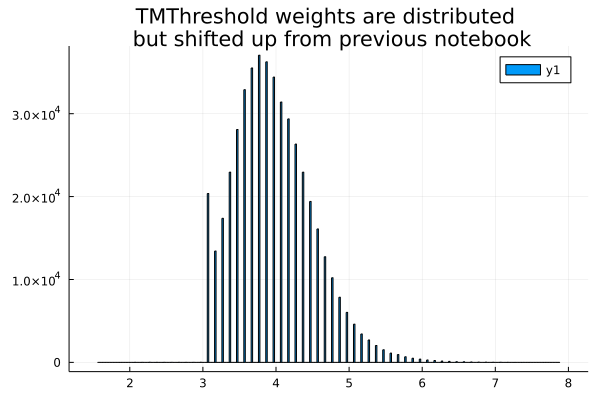

In [20]:
histogram(reshape(tmt.θ, :))
title!("TMThreshold weights are distributed \n but shifted up from previous notebook")

### Prediction

In [21]:
encoding_vecs = hcat([active_cols_to_sparray(tmt, encodings[i]) for i in 1:num_bins]...)
best_match_idx(pred::SparseVector) = argmax(Array(encoding_vecs' * pred))

best_match_idx (generic function with 1 method)

In [22]:
taxi_bin(X[training_len + 1])

18

In [23]:
size(pred)

(7500, 1)

In [24]:
preds = map(X[training_len:end]) do x 
    pred = predict(tmt, encodings[taxi_bin(x)])
    sppred = SparseVector(reshape(pred, :))
    best_match_idx(sppred)
end

2821-element Vector{Int64}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
  1
  1
 72
 70
  1
  1
  1
  1
  1
  1
  1
  1

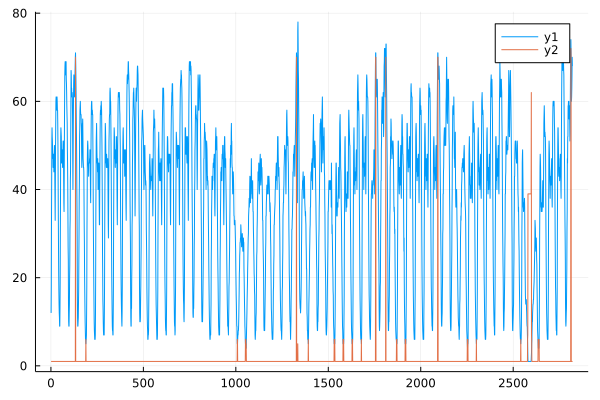

In [25]:
plot(taxi_bin.(X[training_len:end]))
plot!(preds)

In [26]:
pred = predict(tmt, encodings[taxi_bin(X[7501])])
SparseVector(reshape(pred, :))

7500-element SparseVector{Bool, Int64} with 0 stored entries

Looks like it actually got worse than before. We will have to revisit this.